# SA-DBGRU

## Setup

In [1]:
!nvidia-smi

Tue Jun 21 08:32:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import TextVectorization, Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
tfds.disable_progress_bar()

In [3]:
# Load data 
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Dataset = Text (string) + Label (int)
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Performing efficient batching for the potentially large number of training examples, use the `tf.data.Dataset API`. After this step, you would have a `tf.data.Dataset` object of `(target_word, context_word), (label)` elements to train. 

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Each batch pair (text, label) mix by 64 pairs
for example, label in train_dataset.take(1):
  print('Texts: ', example.numpy()[:3])
  print('Labels: ', label.numpy()[:3])

Texts:  [b'So, American Pie: Beta House is the 6th American Pie movie in the series. Although, it really has nothing to do with the original three American Pie movies except some of the characters are supposed to be related to the characters in the original trilogy and Eugene Levy is in it (can\'t that guy get better gigs?).<br /><br />There is very little to compliment this movie on. There aren\'t any funny jokes. The acting is painful to watch, especially the girl with the "southern" accent which sounds more like a Canadian\'s impersonation of a British woman pretending to be a hillbilly by using the word "ya\'ll." This movie makes me feel like such an idiot. Why didn\'t I apply to a college where nobody goes to class (but everybody gets good grades), girls consistently take their clothes off in public, everybody has promiscuous unprotected sex without the burden of babies and STIs, and you can ejaculate all over a girl\'s family photos without her minding? Really, this series has lo

## Encoder

In [5]:
# Size Vocab (dim each word before pass Embedding Layer)
VOCAB_SIZE = 10000

# Embedding Layer Dim: Aim covert large dim to small dim
embedding_dim = 128

In [6]:
encoder = tf.keras.layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
# After the padding and unknown tokens they're sorted by frequency
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it'],
      dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of **indices are 0-padded to the longest sequence in the batch** (unless you set a fixed `output_sequence_length`):

In [8]:
# Width of list = size of longest sequence choose from batch
encoded_example = encoder(example)[:3].numpy()
encoded_example.shape

(3, 921)

## DBGRU

### Architecture


![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

**Architecture of Bidirectional Model:**
1. This model can be build as a `Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

 This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


**Architecture of Deep Bidirectional Model:**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer

### Model 

In [9]:
model_dbgru = Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()),
        output_dim = 128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # Deep Bidirectional GRU 
    Bidirectional(GRU(64, return_sequences = True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dense(1, activation = "sigmoid")])

model_dbgru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        74496     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                        

In [10]:
# Compile
model_dbgru.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(5 * 1e-3),
              metrics= 'acc' )

# Early Stopping
callback = EarlyStopping(patience=1)

# Train 
history_dbgru = model_dbgru.fit(train_dataset, 
                                epochs= 10,
                                validation_data = test_dataset,
                                callbacks=[callback])

Epoch 1/10
196/196 [==============================] - 72s 291ms/step - loss: 0.4324 - acc: 0.7958 - val_loss: 0.2868 - val_acc: 0.8824
Epoch 2/10
196/196 [==============================] - 53s 268ms/step - loss: 0.1979 - acc: 0.9254 - val_loss: 0.2958 - val_acc: 0.8794


In [11]:
# Evaluation
test_loss, test_acc = model_dbgru.evaluate(test_dataset)

196/196 [==============================] - 17s 88ms/step - loss: 0.2958 - acc: 0.8794


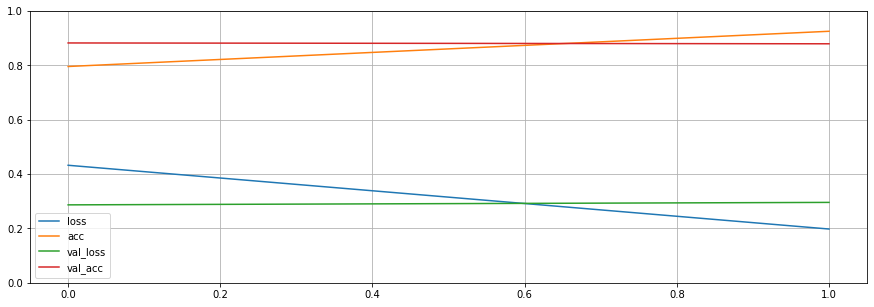

In [12]:
# Visualization
pd.DataFrame(history_dbgru.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1);

In [13]:
# Predict
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

model_dbgru.predict(np.array([sample_text]))

array([[0.8952196]], dtype=float32)